In [1]:
import numpy as np
import pandas as pd

from IPython.display import Image, YouTubeVideo

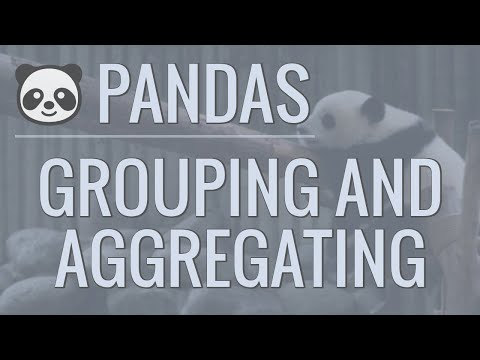

In [2]:
YouTubeVideo(id='txMdrV1Ut64', width=900, height=400)

pandas supports Series and DataFrame manipulation operations which are similar in spirit to what can be done with a database and SQL language, but in a more intuitive and expressive way and much more efficiently since the operations are all take place in memory.

You can concatenate (concat) DataFrame, make joins (merge), make groupings (groupby) or reorganize indexes (pivot).


### Concatenations with concat

`concat` is used to concatenate `Series` or `DataFrame`. Let's look at an example.

In [3]:
s1 = pd.Series([30, 35], index=['alice', 'bob'])
s2 = pd.Series([32, 22, 29], index=['bill', 'alice', 'jo'])

In [4]:
s1

alice    30
bob      35
dtype: int64

In [5]:
s2

bill     32
alice    22
jo       29
dtype: int64

In [6]:
pd.concat([s1, s2])

alice    30
bob      35
bill     32
alice    22
jo       29
dtype: int64

Note, however, that by default there is no control over duplicate index labels. You can correct this with the **`verify_integrity`** argument, which will throw an exception if there are common index labels. Obviously, this has an additional computational cost, so it should only be used if **necessary**.

In [8]:
try:
    pd.concat([s1, s2], verify_integrity=True)
except ValueError as e:
    print(f"concatenation error:\n{e}")

concatenation error:
Indexes have overlapping values: Index(['alice'], dtype='object')


In [9]:
# create two Series with the indexes without overlap
s1 = pd.Series(range(1000), index=[chr(x) for x in range(1000)])
s2 = pd.Series(range(1000), index=[chr(x+2000) for x in range(1000)])

In [10]:
# concatenation time with overlap checking
%timeit pd.concat([s1, s2], verify_integrity=True)

797 µs ± 104 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
# concatenation time without checking overlaps
%timeit pd.concat([s1, s2])

492 µs ± 55.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


By default, concat concatenates the lines, i.e. s2 will be under s1, but we can change this behavior using the axis argument:

In [12]:
p1 = pd.DataFrame(np.random.randint(1, 10, size=(2,2)),
                  columns=list('ab'), index=list('xy'))
p2 = pd.DataFrame(np.random.randint(1, 10, size=(2,2)),
                  columns=list('ab'), index=list('zt'))

In [13]:
p1

,a,b
x,3,4
y,9,2


In [14]:
p2

,a,b
z,5,5
t,6,4


In [15]:
# equivalent to pd.concat ([p1, p2], axis = 0)
# row concatenation
pd.concat([p1, p2])

,a,b
x,3,4
y,9,2
z,5,5
t,6,4


In [16]:
p1 = pd.DataFrame(np.random.randint(1, 10, size=(2,2)),
                  columns=list('ab'), index=list('xy'))
p2 = pd.DataFrame(np.random.randint(1, 10, size=(2,2)),
                  columns=list('cd'), index=list('xy'))

In [17]:
p1

,a,b
x,7,6
y,8,3


In [18]:
p2

,c,d
x,9,1
y,9,8


In [19]:
# concatenation of columns
pd.concat([p1, p2], axis = 1)

,a,b,c,d
x,7,6,9,1
y,8,3,9,8


Now let's look at this case:

In [20]:
pd.concat([p1, p2])

,a,b,c,d
x,7.0,6.0,NaN,NaN
y,8.0,3.0,NaN,NaN
x,NaN,NaN,9.0,1.0
y,NaN,NaN,9.0,8.0


You notice that during the concatenation, we take the union of all the labels of the indexes of `p1` and `p2`, so there are missing values which are set to `NaN`. We can control this behavior in several ways as we will see below.

By default (what we did above), join uses the so-called `outer` strategy, i.e. we take the union of labels.

In [21]:
# we concatenate the lines, the join argument decides which labels we keep
# on the other axis (here on the columns).

# if we specify 'inner' we take the intersection of the labels
# so there is nothing left ..
pd.concat([p1, p2], join='inner')

""
x
y
x
y


With reindex, we can specify the labels we want to keep in the index of rows (axis = 0, this is the default value) or columns (axis = 1):

In [22]:
# we can reindex a list of labels ...
pd.concat([p1, p2], axis=1).reindex(['x'])

,a,b,c,d
x,7,6,9,1


In [23]:
# or an Index object
# For the columns I specify a reindex with axis = 1
pd.concat([p1, p2], axis=1).reindex(p2.columns, axis=1)

,c,d
x,9,1
y,9,8


In [24]:
pd.concat([p1, p2], axis=1).reindex(['a', 'b'], axis=1)

,a,b
x,7,6
y,8,3


Note that the Series and DataFrame have an append method which is a shortcut to concat, but with fewer options.

To go further, here is the official documentation:
https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

### Joins with merge

`merge` is similar in spirit to `JOIN` in `SQL`. The idea is to combine two `DataFrame` according to an equality criterion on `columns`. Let's look at an example:

In [25]:
df1 = pd.DataFrame({'employee': ['Bob', 'Lisa', 'Sue'],
                    'group': ['Accounting', 'Engineering', 'HR']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Sue'],
                    'hire_date': [2004, 2008, 2014]})

In [26]:
df1

,employee,group
0,Bob,Accounting
1,Lisa,Engineering
2,Sue,HR


In [27]:
df2

,employee,hire_date
0,Lisa,2004
1,Bob,2008
2,Sue,2014


Here we want to combine `df1` and `df2` so that the lines containing the same employee are aligned. Our merge criterion is therefore the equality of the labels on the employee column.

In [28]:
pd.merge(df1, df2)

,employee,group,hire_date
0,Bob,Accounting,2008
1,Lisa,Engineering,2004
2,Sue,HR,2014


By default, merge does an inner join (or inner join) using columns of the same name (here employee) as join criteria. inner join means that to join two lines, the same employee must appear in both DataFrame.

There are three types of merges:

  * one-to-one, this is the one we just saw. This is the merge when there are no duplicate labels in the columns used as merge criteria;

  * many-to-one, this is the merge when one of the two columns contains duplicate labels, in this case, we apply the one-to-one strategy for each duplicate label, so duplicate entries are preserved;

  * many-to-many, this is the strategy when there are duplicate entries in both columns. In this case, we make a Cartesian product of the lines.

In general, keep in mind that pandas basically do what you expect. Let's look at this on examples:

In [36]:
df1 = pd.DataFrame({'patient': ['Bob', 'Lisa', 'Sue'],
                    'repas': ['NS', 'NS', 'NSR']})
df2 = pd.DataFrame({'repas': ['NS', 'NSR'],
                    'explication': ['no salt', 'no sugar']})

In [37]:
df1

,patient,repas
0,Bob,NS
1,Lisa,NS
2,Sue,NSR


In [38]:
df2

,repas,explication
0,NS,no salt
1,NSR,no sugar


In [39]:
# the common column for the merge is 'meal' and in one of the columns
# (on df1), there are duplicate labels, we apply the many-to-one strategy
pd.merge(df1, df2)

,patient,repas,explication
0,Bob,NS,no salt
1,Lisa,NS,no salt
2,Sue,NSR,no sugar


In [41]:
df1 = pd.DataFrame({'patient': ['Bob', 'Lisa', 'Sue'],
                    'meals': ['NS', 'NS', 'NSR']})
df2 = pd.DataFrame({'meals': ['NS', 'NS', 'NSR'],
                    'explication': ['no salt', 'vegetables', 'no sugar']})

In [42]:
df1

,patient,meals
0,Bob,NS
1,Lisa,NS
2,Sue,NSR


In [43]:
df2

,meals,explication
0,NS,no salt
1,NS,vegetables
2,NSR,no sugar


In [44]:
# the common column for the merge is 'meal' and in both columns
# there are duplicate labels, we apply the many-to-many strategy
pd.merge(df1, df2)

,patient,meals,explication
0,Bob,NS,no salt
1,Bob,NS,vegetables
2,Lisa,NS,no salt
3,Lisa,NS,vegetables
4,Sue,NSR,no sugar


In a merge, you can control which columns to use as merge criteria. Let's look at these different cases on examples:

In [45]:
df1 = pd.DataFrame({'employee': ['Bob', 'Lisa', 'Sue'],
                    'group': ['Accounting', 'Engineering', 'HR']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Sue'],
                    'hire_date': [2004, 2008, 2014]})

In [46]:
df1

,employee,group
0,Bob,Accounting
1,Lisa,Engineering
2,Sue,HR


In [47]:
df2

,employee,hire_date
0,Lisa,2004
1,Bob,2008
2,Sue,2014


In [48]:
# we decide to use the column 'employee' as merge criterion
pd.merge (df1, df2, on = 'employee')

,employee,group,hire_date
0,Bob,Accounting,2008
1,Lisa,Engineering,2004
2,Sue,HR,2014


In [49]:
df1 = pd.DataFrame({'employee': ['Bob', 'Lisa', 'Sue'],
                    'group': ['Accounting', 'Engineering', 'HR']})
df2 = pd.DataFrame({'name': ['Lisa', 'Bob', 'Sue'],
                    'hire_date': [2004, 2008, 2014]})

In [50]:
df1

,employee,group
0,Bob,Accounting
1,Lisa,Engineering
2,Sue,HR


In [51]:
df2

,name,hire_date
0,Lisa,2004
1,Bob,2008
2,Sue,2014


In [52]:
# but we can also define a different column name
# to the left and to the right
m = pd.merge(df1,df2, left_on='employee', right_on='name')
m

,employee,group,name,hire_date
0,Bob,Accounting,Bob,2008
1,Lisa,Engineering,Lisa,2004
2,Sue,HR,Sue,2014


In [53]:
# in this case, as we keep the columns used as criteria in
# the result of the merge, we can delete the unnecessary column as well
m.drop('name', axis = 1)

,employee,group,hire_date
0,Bob,Accounting,2008
1,Lisa,Engineering,2004
2,Sue,HR,2014


`merge` also allows you to control the strategy to apply when there are values in one column used as merge criteria that are missing in the other column. This is known as a left join, right join, inner join (default behavior), and outer join. For those who are not familiar with these notions, let's look at some examples:

In [54]:
df1 = pd.DataFrame({'name': ['Bob', 'Lisa', 'Sue'],
                    'pulse': [70, 63, 81]})
df2 = pd.DataFrame({'name': ['Eric', 'Bob', 'Marc'],
                    'weight': [60, 100, 70]})

In [55]:
df1

,name,pulse
0,Bob,70
1,Lisa,63
2,Sue,81


In [56]:
df2

,name,weight
0,Eric,60
1,Bob,100
2,Marc,70


In [57]:
# the 'name' column is the merge criterion in the two DataFrame.
# Only Bob exists in both columns. In an inner join
# (the default case) we keep only the lines for which there is a
# same value present on left and right
pd.merge(df1, df2) # equivalent to pd.merge (df1, df2, how = 'inner')

,name,pulse,weight
0,Bob,70,100


In [58]:
# the outer join will instead make a union of the lines and complete this
# which is missing with NaN
pd.merge (df1, df2, how = 'outer')

,name,pulse,weight
0,Bob,70.0,100.0
1,Lisa,63.0,NaN
2,Sue,81.0,NaN
3,Eric,NaN,60.0
4,Marc,NaN,70.0


In [59]:
# le left join ne garde que les valeurs de la colonne de gauche
pd.merge(df1, df2, how='left')

,name,pulse,weight
0,Bob,70,100.0
1,Lisa,63,NaN
2,Sue,81,NaN


In [60]:
# et le right join ne garde que les valeurs de la colonne de droite
pd.merge(df1, df2, how='right')

,name,pulse,weight
0,Eric,NaN,60
1,Bob,70.0,100
2,Marc,NaN,70


Pour aller plus loin, vous pouvez lire la documentation. Vous verrez notamment que vous pouvez merger sur les index (au lieu des colonnes) ou le cas où vous avez des colonnes de même nom qui ne font pas partie du critère de merge :https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

## Grouping with groupby

Let us now look at this notion of grouping. This is a very powerful notion with many options that we will only partially cover. The logic behind groupby is to create groups in a DataFrame based on the values of one (or more) column (s), all rows containing the same value are in the same group. We can then apply to each group operations which are:

   - either calculations on each group;
   - either a filter on each group which can keep or delete a group;
   - or a transformation that will modify the whole group (for example, to center the values on the group mean).

Let's look at some examples:

In [61]:
d = pd.DataFrame({'key': list('ABCABC'), 'val': range(6)})
d

,key,val
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


In [62]:
# use as grouping column 'key'
g = d.groupby('key')
g

`groupby` produces a new object, but does not do any calculations. The calculations will be performed when a function is called on this new object. For example, let's calculate the sum for each group.

In [63]:
g.sum()

,val
key,
A,3
B,5
C,7


`groupby` can use a column, a list of columns, or an index as a grouping criterion (this is particularly useful for Series).

A particularity of groupby is that the grouping criterion becomes an `index` in the new generated object. The advantage is that we now have optimized access to this criterion, but the disadvantage is that on certain operations which destroy the `index`, this criterion can be lost. We can control this behavior with `as_index`.

In [64]:
g = d.groupby('key', as_index=False)
g.sum()

,key,val
0,A,3
1,B,5
2,C,7


The object produced by group by allows you to manipulate groups, let's look at this:

In [65]:
d = pd.DataFrame({'key': list('ABCABC'),
                  'val1': range(6),
                  'val2' : range(100, 106)})
d

,key,val1,val2
0,A,0,100
1,B,1,101
2,C,2,102
3,A,3,103
4,B,4,104
5,C,5,105


In [66]:
g = d.groupby('key')
# g.groups gives access to the dictionary of groups,
# the keys are the name of the group
# and the values the indexes of the rows
# belonging to the group
g.groups

{'A': [0, 3], 'B': [1, 4], 'C': [2, 5]}

In [67]:
# to directly access the group, we can use get_group
g.get_group('A')

,key,val1,val2
0,A,0,100
3,A,3,103


In [68]:
# we can also filter a group by column
# during an operation
g.sum()['val2']

key
A    203
B    205
C    207
Name: val2, dtype: int64

In [69]:
# or directly on the object produced by groupby
g['val2'].sum()

key
A    203
B    205
C    207
Name: val2, dtype: int64

We can also iterate over groups with a classic `for` loop:

In [70]:
import seaborn as sns
# we load the tip data file
tips = sns.load_dataset('tips')

# As a reminder
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [71]:
# we group the DataFrame by days
g = tips.groupby('day')

# we calculate the average tip per day
for (group, index) in g:
    print(f"On {group} the mean tip is {index['tip'].mean():.3}")

On Thur the mean tip is 2.77
On Fri the mean tip is 2.73
On Sat the mean tip is 2.99
On Sun the mean tip is 3.26


The object produced by groupby supports what is called method dispatch. If a method is not directly defined on the object produced by groupby, it is called on each group (it must therefore be defined on the `DataFrame` or the `Series`). Let's look at this:

In [72]:
# we group by day and we extract only the column 'total_bill'
# for each group
g = tips.groupby('day')['total_bill']

# we ask pandas to display floats with only two digits
# after comma
pd.set_option('display.float_format', '{:.2f}'.format)

# we call describe () on g, but it is not defined on this object,
# it will therefore be called (dispatch) on each group
g.describe()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
Thur,62.00,17.68,7.89,7.51,12.44,16.20,20.16,43.11
Fri,19.00,17.15,8.30,5.75,12.09,15.38,21.75,40.17
Sat,87.00,20.44,9.48,3.07,13.91,18.24,24.74,50.81
Sun,76.00,21.41,8.83,7.25,14.99,19.63,25.60,48.17


In [76]:
# But, there are still a large number of methods
# defined directly on the object produced by the groupby

methods = [x for x in dir (g) if not x.startswith ('_')]
f"The type {type(g).__name__} exposes {len(methods)} methods."

'The type SeriesGroupBy exposes 69 methods.'

In [77]:
# take advantage of the layout of the dataframes
# to display these methods on multiple columns
# we do a little gymnastics
# there is also surely simpler ..
columns = 7
nb_methods = len(methods)
nb_pad = (columns - nb_methods % columns) % columns

array = np.array(methods + nb_pad * ['']).reshape((columns, -1))

In [78]:
pd.DataFrame(data=array.transpose())

,0,1,2,3,4,5,6
0,agg,cumcount,fillna,is_monotonic_decreasing,ngroups,prod,std
1,aggregate,cummax,filter,is_monotonic_increasing,nlargest,quantile,sum
2,all,cummin,first,last,nsmallest,rank,tail
3,any,cumprod,get_group,mad,nth,resample,take
4,apply,cumsum,groups,max,nunique,rolling,transform
5,backfill,describe,head,mean,ohlc,sample,tshift
6,bfill,diff,hist,median,pad,sem,unique
7,corr,dtype,idxmax,min,pct_change,shift,value_counts
8,count,expanding,idxmin,ndim,pipe,size,var
9,cov,ffill,indices,ngroup,plot,skew,


We will look at the `aggregate` method (whose alias is agg). This method allows to apply a function (or list of functions) to each group with the possibility of applying a function to a specific column of the group.

A subtlety of `aggregate` is that you can pass either a function object or a function name as a `str`. For the use of the name of the function to work, the function must be defined on the object produced by the `groupby` or that it be defined on the groups (therefore with dispatching).

In [79]:
# calculate the mean and variance for each group
# and each numeric column
tips.groupby('day').agg(['mean', 'std'])

total_bill       tip      size     
           mean  std mean  std mean  std
day                                     
Thur      17.68 7.89 2.77 1.24 2.45 1.07
Fri       17.15 8.30 2.73 1.02 2.11 0.57
Sat       20.44 9.48 2.99 1.63 2.52 0.82
Sun       21.41 8.83 3.26 1.23 2.84 1.01

In [80]:
# in an equivalent way with function objects
tips.groupby('day').agg([np.mean, np.std])

total_bill       tip      size     
           mean  std mean  std mean  std
day                                     
Thur      17.68 7.89 2.77 1.24 2.45 1.07
Fri       17.15 8.30 2.73 1.02 2.11 0.57
Sat       20.44 9.48 2.99 1.63 2.52 0.82
Sun       21.41 8.83 3.26 1.23 2.84 1.01

In [81]:
# by applying a different function for each column,
# we then pass a dictionary whose key is the name of the
# column and for value the function to apply to this column
tips.groupby('day').agg({'tip': np.mean, 'total_bill': np.std})

,tip,total_bill
day,,
Thur,2.77,7.89
Fri,2.73,8.30
Sat,2.99,9.48
Sun,3.26,8.83


The purpose of the `filter` method is to filter the groups according to a criterion. But be careful, `filter` returns a **subset** of the original data in which the elements belonging to the filtered groups have been removed.

In [82]:
d = pd.DataFrame({'key': list('ABCABC'), 
                  'val1': range(6),
                  'val2' : range(100, 106)})
d

,key,val1,val2
0,A,0,100
1,B,1,101
2,C,2,102
3,A,3,103
4,B,4,104
5,C,5,105


In [83]:
# sum of group
d.groupby('key').sum()

,val1,val2
key,,
A,3,203
B,5,205
C,7,207


In [84]:
# now keep all lines in the original data
# for which the sum of their group is greater than 3
# (here groups B and C)
d.groupby('key').filter(lambda x: x['val1'].sum() > 3)

,key,val1,val2
1,B,1,101
2,C,2,102
4,B,4,104
5,C,5,105


The `transform` method aims to return a **subset of the original data** in which a function has been applied by group. A classic use is to center values by group, or to replace the `NaN` of a group by the mean value of the group.

Be careful, transform must not make any modifications in place, otherwise the result may be false. So be careful not to apply functions that make changes in place.

In [85]:
r = np.random.normal(0.5, 2, 4)
d = pd.DataFrame({'key': list('ab'*2), 'data': r,'data2': r*2})
d

,key,data,data2
0,a,4.53,9.07
1,b,-1.77,-3.55
2,a,-3.11,-6.23
3,b,-4.92,-9.84


In [86]:
# I group on the 'key' column
g = d.groupby('key')

In [87]:
# now I center each group in relation to its average
g.transform(lambda x: x - x.mean())

,data,data2
0,3.82,7.65
1,1.57,3.15
2,-3.82,-7.65
3,-1.57,-3.15


Note that the key column has disappeared, this behavior is explained here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html